## Import Data

In [1]:
import pandas as pd
import numpy as np
import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train.shape, test.shape

((891, 12), (418, 11))

## Training Data Exploration

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Missing Values

In [4]:
# Check for NaN values and data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Correlation

In [5]:
# Check for correlation between features
pd.get_dummies(train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)).corr()["Survived"].sort_values(ascending = False)

Survived      1.000000
Sex_female    0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.077221
Embarked_S   -0.155660
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64

In [6]:
train_age = train[["Survived", "Age"]]
train_age = train_age.fillna(train_age["Age"].median())
train_age[["Survived", "Age"]].corr()["Survived"].sort_values(ascending = False)

Survived    1.00000
Age        -0.06491
Name: Survived, dtype: float64

In [7]:
pd.get_dummies(train[["Survived", "Cabin"]]).corr()["Survived"].sort_values(ascending = False)

Survived         1.000000
Cabin_B96 B98    0.085083
Cabin_F33        0.073642
Cabin_E101       0.073642
Cabin_D33        0.060095
                   ...   
Cabin_B102      -0.026456
Cabin_A24       -0.026456
Cabin_D26       -0.037436
Cabin_C124      -0.037436
Cabin_F G73     -0.037436
Name: Survived, Length: 148, dtype: float64

In [8]:
pd.get_dummies(train[["Survived", "Ticket"]]).corr()["Survived"].sort_values(ascending = False)

Survived           1.000000
Ticket_113760      0.085083
Ticket_2666        0.085083
Ticket_PC 17572    0.073642
Ticket_PC 17755    0.073642
                     ...   
Ticket_347088     -0.064988
Ticket_3101295    -0.064988
Ticket_CA 2144    -0.064988
Ticket_347082     -0.070234
Ticket_CA. 2343   -0.070234
Name: Survived, Length: 682, dtype: float64

## Custom Features

### Family Size

In [9]:
# Create a feature called "FamilySize" combining "SibSp" and "Parch"
train_custom = train.copy()
train_custom["FamilySize"] = train_custom["SibSp"] + train_custom["Parch"]
train_custom[["Survived", "FamilySize"]].corr()["Survived"].sort_values(ascending = False) # Low correlation

Survived      1.000000
FamilySize    0.016639
Name: Survived, dtype: float64

### Name Titles

In [10]:
# Create a "NameTitle" feature extracting the title of each passenger
!pip install nameparser
from nameparser import HumanName

def name_title(X):
    names = []
    for name in X["Name"]:
        names.append(HumanName(name).title)
    X["NameTitle"] = names
    
def best_title(X):
    min_titles = (X["NameTitle"].value_counts() < 50)
    for title in X["NameTitle"]:
        if min_titles.loc[title] == True:
            X.loc[X["NameTitle"] == title, "NameTitle"] = "Misc"
            
# Solution using lambda functions:
# train_custom["NameTitle"] = train_custom["Name"].apply(lambda x: HumanName(x).title)
# min_titles = (train_custom["NameTitle"].value_counts() < 50)
# train_custom["NameTitle"] = train_custom["NameTitle"].apply(lambda x: "Misc" if min_titles.loc[x] == True else x)

# Check correlation
name_title(train_custom)
best_title(train_custom)
pd.get_dummies(train_custom[["Survived", "NameTitle"]]).corr()["Survived"].sort_values(ascending = False)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Survived           1.000000
NameTitle_Mrs.     0.339040
NameTitle_Miss.    0.327093
NameTitle_Misc     0.081238
NameTitle_Mr.     -0.549199
Name: Survived, dtype: float64

### Single Passenger

In [11]:
def alone(X):
    X["Single"] = 0
    for i, value in enumerate(X["FamilySize"]):
        if value == 0:
            X["Single"][i] = 1
            
alone(train_custom)
train_custom[["Survived", "Single"]].corr()["Survived"].sort_values(ascending = False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Survived    1.000000
Single     -0.203367
Name: Survived, dtype: float64

## Data Preparation

In [12]:
# Select independent and dependent variables
X = train[["Sex", "Fare", "Embarked", "Pclass", "Name", "Age", "Parch", "SibSp"]]
y = train["Survived"]

# Convert Pclass data type from int to object
pd.options.mode.chained_assignment = None
X["Pclass"] = X["Pclass"].astype("object")

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       891 non-null    object 
 1   Fare      891 non-null    float64
 2   Embarked  889 non-null    object 
 3   Pclass    891 non-null    object 
 4   Name      891 non-null    object 
 5   Age       714 non-null    float64
 6   Parch     891 non-null    int64  
 7   SibSp     891 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 55.8+ KB


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib.pyplot import plot

# Set style for visualizations
style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Numerical Features Distributions

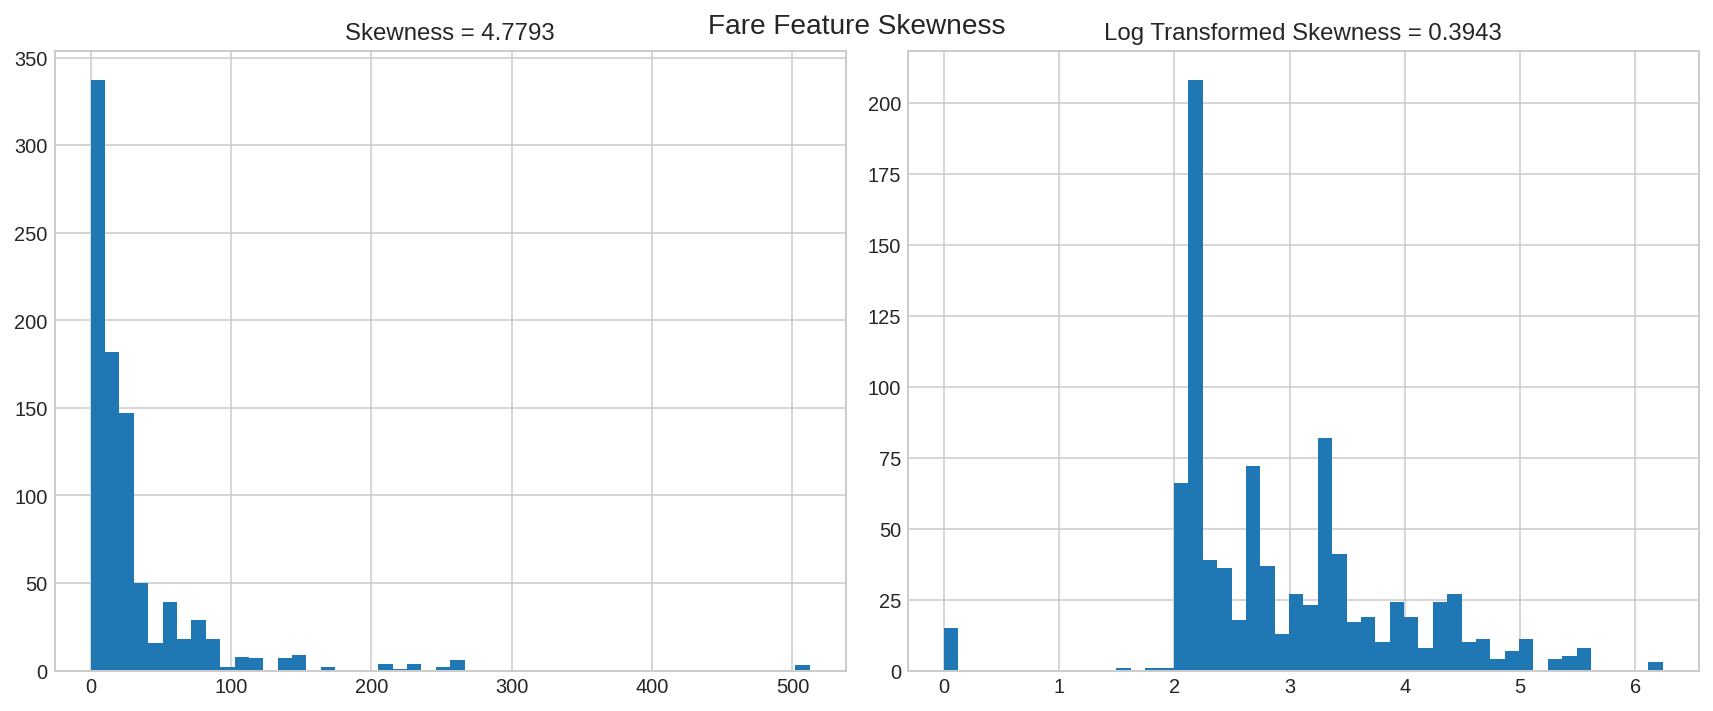

In [15]:
from scipy import stats

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes[0].hist(X["Fare"], bins = 50)
axes[0].set_title("Skewness = " + str(round(stats.skew(X["Fare"]), 4)))
axes[1].hist(np.log(1 + X["Fare"]), bins = 50)
axes[1].set_title("Log Transformed Skewness = " + str(round(stats.skew(np.log(1 + X["Fare"])), 4)))
fig.suptitle("Fare Feature Skewness", fontsize = 14)
fig.tight_layout()

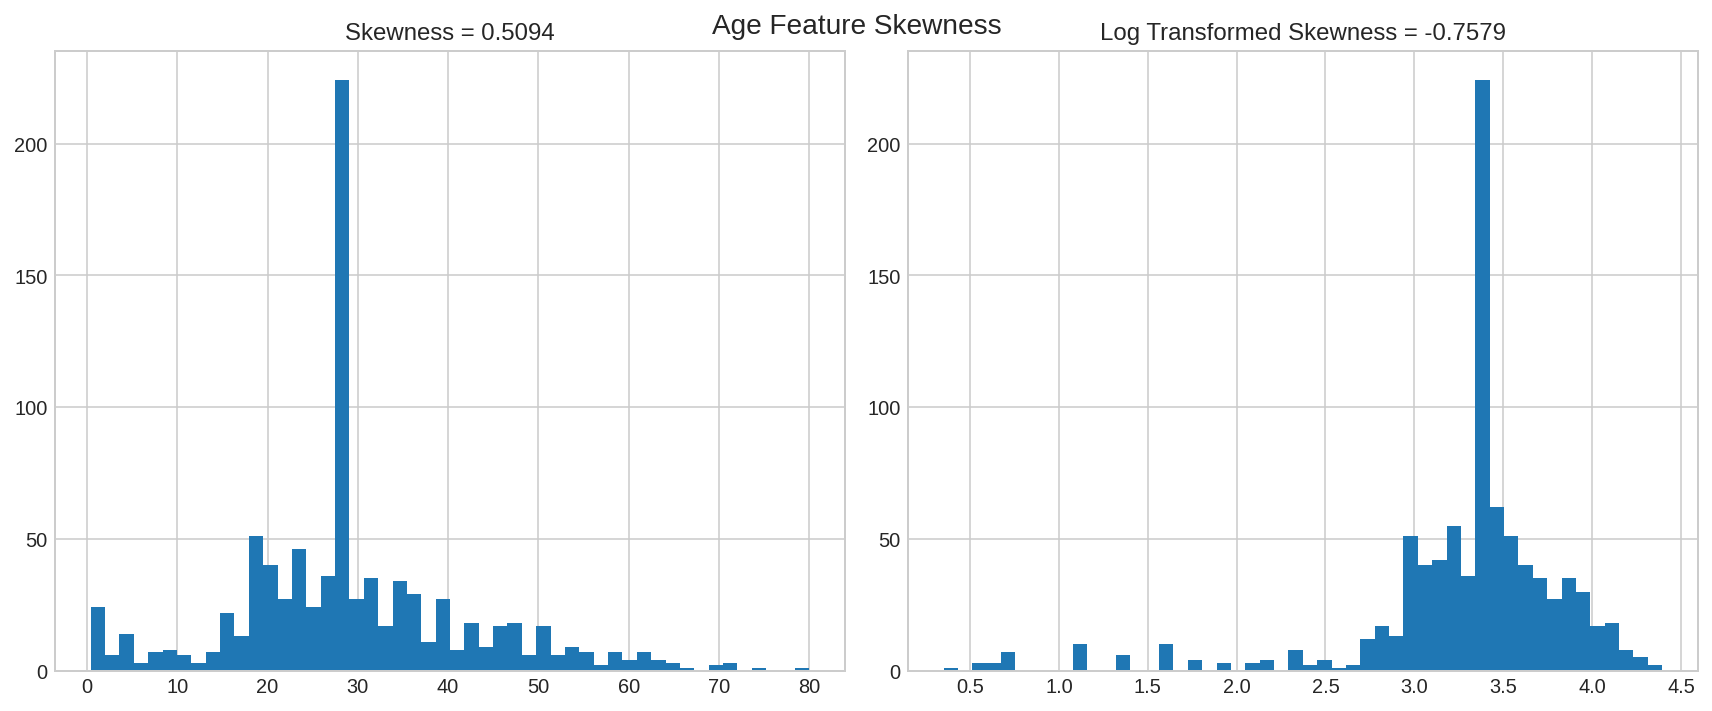

In [16]:
# No need for transformation
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes[0].hist(train_age["Age"], bins = 50)
axes[0].set_title("Skewness = " + str(round(stats.skew(train_age["Age"]), 4)))
axes[1].hist(np.log(1 + train_age["Age"]), bins = 50)
axes[1].set_title("Log Transformed Skewness = " + str(round(stats.skew(np.sqrt(train_age["Age"])), 4)))
fig.suptitle("Age Feature Skewness", fontsize = 14)
fig.tight_layout()

### Data Preparation Pipeline

In [17]:
# Custom pipeline for data preparation

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Select numerical and categorical features
numerical_features = X.select_dtypes(include = ["int64", "float64"]).columns
categorical_features = X.select_dtypes(include = ["object", "bool"]).columns

# Define custom transformer for log transformation of "Fare" feature
class log_transform(BaseEstimator, TransformerMixin):        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X[:, 0] = np.log(1 + X[:, 0])
        return X
    
# Define custom transformer for name title extraction   
class name_transform(BaseEstimator, TransformerMixin):        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X): 
        names = []
        for name in X[:, 3]:
            names.append(HumanName(name).title)
        names = np.array(names)
        names = np.expand_dims(names, axis = 1)
        X = np.append(X, names, axis = 1)
        X = np.delete(X, 3, 1)
        min_titles = ["Mr.", "Mrs.", "Miss."]
        for i, title in enumerate(X[:, 3]):
                if title in min_titles:
                    X[:, 3][i] = title
                else:
                    X[:, 3][i] = "Misc"
        return X

# Define custom transformer to create single passenger feature
class single(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        # FamilySize
        family_size = X[:, 2] + X[:, 3]
        family_size = np.expand_dims(family_size, axis = 1)
        X = np.append(X, family_size, axis = 1)
        
        # SinglePassenger
        z = np.zeros((X.shape[0], 1), dtype = "int64")
        X = np.append(X, z, axis = 1)
        for i, value in enumerate(X[:, 4]):
            if value == 0:
                X[:, 5][i] = 1
        
        # Drop Parch, SibSp, FamilySize features
        X = np.delete(X, [2, 3, 4], 1)
        return X

# Impute all missing values with the median value,
# Rescale features using Min-Max scaler, range 0-1
numerical_transformer = Pipeline(steps = [
    ("impute", SimpleImputer(strategy = "median")),
    ("log_transform", log_transform()),
    ("single_passenger", single()),
    ("scaler", MinMaxScaler())])

# Impute all missing values using the most frequent value,
# One-Hot encode all categorical values
categorical_transformer = Pipeline(steps = [
    ("impute", SimpleImputer(strategy = "most_frequent")),
    ("names", name_transform()),
    ("onehot", OneHotEncoder())])

# Combine numerical and categorical transformers for final pipeline
transformer = ColumnTransformer(transformers = [
    ("transform_numeric", numerical_transformer, numerical_features),
    ("transform_categorical", categorical_transformer, categorical_features)], 
                                verbose = True)

### Data Split

In [18]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(transformer.fit_transform(X), y, 
                                                    test_size = 0.2, shuffle = True, random_state = 10)

[ColumnTransformer]  (1 of 2) Processing transform_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing transform_categorical, total=   0.1s


## Perceptron Benchmark

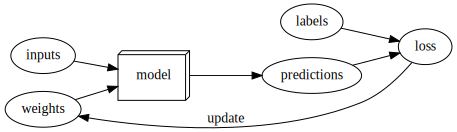

In [19]:
import graphviz

# Draw basic architecture of model
def gv(x): 
    return graphviz.Source('digraph G{ rankdir="LR"' + x + '; }')

# Predictions are calculated from the independent variables, which is the data not including the labels.
# The results of the model are called predictions, the measure of performance is called the loss.
# The loss depends not only on the predictions, but also the correct labels.

gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=model]
inputs->model->predictions; weights->model; labels->loss; predictions->loss
loss->weights[constraint=false label=update]''')

In [20]:
from sklearn.linear_model import Perceptron

# Fit and train perceptron algorithm
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
print("Perceptron Benchmark Performance : " + str(round(perceptron.score(X_test, y_test), 4)))

Perceptron Benchmark Performance : 0.8324


### Benchmark Predictions

In [21]:
# Create predictions for submission
bench_preds = perceptron.predict(transformer.fit_transform(
    test.drop(["PassengerId", "Cabin", "Ticket"], axis = 1)))

[ColumnTransformer]  (1 of 2) Processing transform_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing transform_categorical, total=   0.1s


In [22]:
# Create submission file
bench_sub = pd.DataFrame({"PassengerId" : test.PassengerId, "Survived" : bench_preds})
bench_sub.to_csv("bench_sub.csv", index = False)
bench_sub.head(5)

# Performance on submission data ~0.77

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## MLP with Hyperparameter Optimization

In [23]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

def MLP(hp):
    
    # Create a sequential MLP model which consists of a single 
    # stack of layers connected sequentially
    model = keras.Sequential()
    
    # Input layer with one neuron for each feature
    model.add(keras.layers.Input(shape = X_train.shape[1]))
    
    # Add batch normalization layer for normalizing input
    # Add dropout layer for regularization
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    
    # Tune the number of TLU's in the first dense layer
    # First hidden layer with ReLU activation function and "He" initialization,
    # each dense layer manages it's own weight matrix and bias vector
    hp_units_1 = hp.Int("units_1", min_value = 16, max_value = 256, step = 16)
    model.add(keras.layers.Dense(units = hp_units_1, activation = "relu", 
                                 kernel_initializer = "he_normal", use_bias = False))
      
    # Add batch normalization layer for normalizing input
    # Add dropout layer for regularization
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    
    # Tune the number of TLU's in the second dense layer
    # Second hidden layer with ReLU activation function and "He" initialization, 
    # each dense layer manages it's own weight matrix and bias vector
    hp_units_2 = hp.Int("units_2", min_value = 16, max_value = 256, step = 16)
    model.add(keras.layers.Dense(units = hp_units_2, activation = "relu", 
                                 kernel_initializer = "he_normal", use_bias = False))
    
    # Add batch normalization layer for normalizing input
    # Add dropout layer for regularization
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    
    # Tune the number of TLU's in the third dense layer
    # Third hidden layer with ReLU activation function and "He" initialization, 
    # each dense layer manages it's own weight matrix and bias vector
    hp_units_3 = hp.Int("units_3", min_value = 16, max_value = 256, step = 16)
    model.add(keras.layers.Dense(units = hp_units_3, activation = "relu", 
                                 kernel_initializer = "he_normal", use_bias = False))
    
    # Add batch normalization layer for normalizing input
    # Add dropout layer for regularization
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    
    # Output layer with 1 TLU per class and sigmoid activation function
    model.add(keras.layers.Dense(1, activation = "sigmoid"))
    
    # Tune the learning rate for the optimizer 
    hp_learning_rate = hp.Choice("learning_rate", values = [1e-1, 1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])
  
    return model

In [24]:
# Select hyperparameter optimization technique
tuner = kt.Hyperband(MLP, 
                     objective = "val_accuracy", 
                     max_epochs = 100, 
                     factor = 3, 
                     overwrite = True)

In [25]:
import IPython

# Define a callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

# Run the hyperparameter search with early stopping
tuner.search(X_train, y_train, epochs = 100, batch_size = 16, validation_split = 0.3, 
             callbacks = [ClearTrainingOutput(), keras.callbacks.EarlyStopping(patience = 20)], verbose = 0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""The hyperparameter search is complete. The optimal number of TLU's in the first densely-connected
layer is {best_hps.get("units_1")}, the optimal number of TLU's in the second densely-connected
layer is {best_hps.get("units_2")} and the optimal number of TLU's in the third densely-connected
layer is {best_hps.get("units_3")}. The learning rate for the optimizer is {best_hps.get("learning_rate")}.""")

The hyperparameter search is complete. The optimal number of TLU's in the first densely-connected
layer is 208, the optimal number of TLU's in the second densely-connected
layer is 96 and the optimal number of TLU's in the third densely-connected
layer is 64. The learning rate for the optimizer is 0.01.


In [26]:
# Retrain the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 500, batch_size = 16, validation_split = 0.2, verbose = 0)

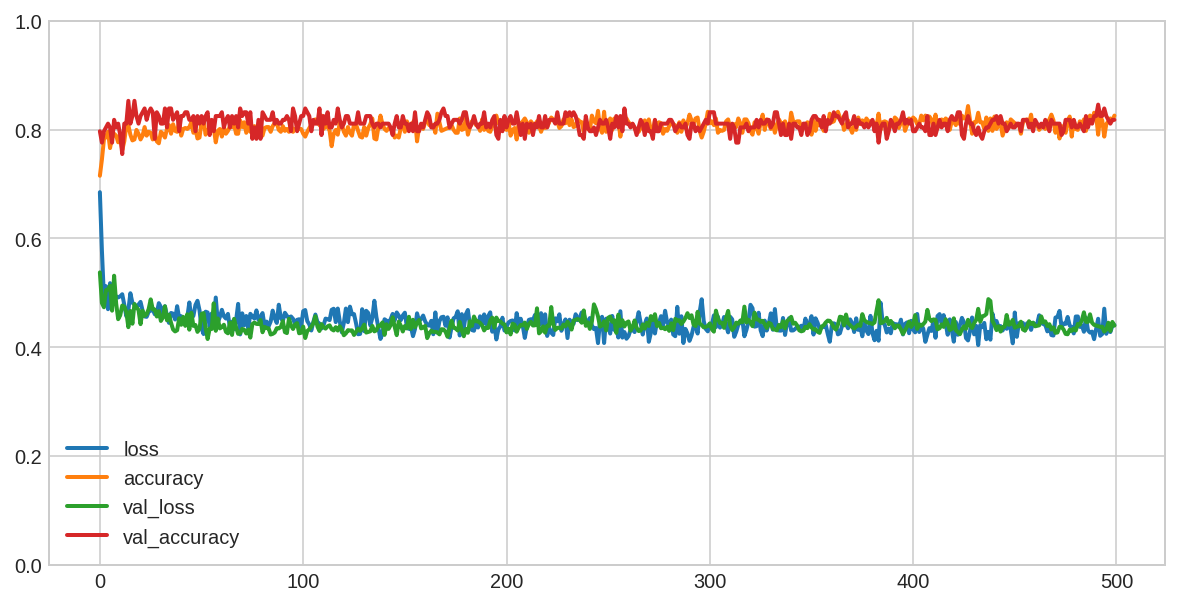

In [27]:
# Plot loss and accuracy
pd.DataFrame(history.history).plot(figsize = (10,5), linewidth = 2)
plt.gca().set_ylim(0, 1)
plt.show()

In [28]:
# Evaluate performance on test data
print("MLP Performance on Testset: " + str(round(model.evaluate(X_test, y_test)[1], 4)))

6/6 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.96 - 0s 2ms/step - loss: 0.3327 - accuracy: 0.8603
MLP Performance on Testset: 0.8603


### Predictions

In [29]:
# Create predictions for submission
predictions = model.predict(transformer.fit_transform(
    test.drop(["PassengerId", "Cabin", "Ticket"], axis = 1)))

[ColumnTransformer]  (1 of 2) Processing transform_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing transform_categorical, total=   0.1s


In [30]:
# Create submission file
predictions = (predictions.ravel() > 0.5).astype(int)
submission = pd.DataFrame({"PassengerId" : test.PassengerId, "Survived" : predictions})
submission.to_csv("submission.csv", index = False)
submission.head(5)

# Performance on submission data ~0.77
# Same performance as simple perceptron

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
